In [2]:
import json
from pathlib import Path

import numpy as np
import SimpleITK
from PIL import Image
from tqdm.auto import tqdm

DATASETS_DIR = Path("/rodata/mnradonc_dev/m299164/trackrad/datasets")

nnUNet_raw = DATASETS_DIR / "nnUNet/nnUNet_raw"
nnUNet_preprocessed = DATASETS_DIR / "nnUNet/nnUNet_preprocessed"
nnUNet_results = DATASETS_DIR / "nnUNet/nnUNet_results"

INPUT_DIR = DATASETS_DIR / "trackrad2025/trackrad2025_labeled_training_data"
SUGGESTED_MASKS_DIR = Path("./train-unet")

In [ ]:
import nibabel as nib

affine = np.eye(4)
dataset_idx = 492
frame_count = 8  # Sliding window length for U-Net input
dataset_name = f"TrackRadSmoothXB{frame_count}"
assert frame_count >= 1

case_dirs = sorted(case for case in INPUT_DIR.iterdir())
count = 0
dataset_dir = nnUNet_raw / f"Dataset{dataset_idx}_{dataset_name}"
dataset_dir.mkdir(parents=True, exist_ok=True)
for train_case in tqdm(case_dirs):
    dataset_json = dataset_dir / "dataset.json"
    images_dir = dataset_dir / "imagesTr"
    labels_dir = dataset_dir / "labelsTr"

    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)

    images_file = train_case / "images" / f"{train_case.name}_frames.mha"
    labels_file = train_case / "targets" / f"{train_case.name}_labels.mha"

    images_array = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(images_file)))
    labels_array = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(labels_file)))
    suggested_mask_pngs = (SUGGESTED_MASKS_DIR / train_case.name / "annotations").glob(
        "*.png"
    )
    suggested_mask_pngs = sorted(suggested_mask_pngs)

    assert images_array.shape[-1] == labels_array.shape[-1] == len(suggested_mask_pngs)

    for i in range(images_array.shape[-1]):
        case_id = f"{train_case.name}-{i:04d}"

        # U-Net input shape == (2, H, W, F), output == (H, W, F)
        # One dim for the raw images, one dim for suggested masks
        # Dimensions should be (H, W, F), where F = sliding window length
        # For frames whose index is < sliding window length, repeat the first frame
        frame_indices = []
        suggested_masks = []
        for j in range(frame_count):
            # Repeat early frames where idx < sliding window length
            frame_idx = max(i - (frame_count - 1) + j, 0)
            suggested_mask = Image.open(suggested_mask_pngs[frame_idx])
            suggested_masks.append(np.array(suggested_mask))
            frame_indices.append(frame_idx)

        images = images_array[..., frame_indices]
        suggested_masks = np.stack(suggested_masks, axis=-1)
        labels = labels_array[..., frame_indices]

        nib.save(
            nib.Nifti1Image(images, affine), str(images_dir / f"{case_id}_0000.nii.gz")
        )
        nib.save(
            nib.Nifti1Image(suggested_masks, affine),
            str(images_dir / f"{case_id}_0001.nii.gz"),
        )
        nib.save(nib.Nifti1Image(labels, affine), str(labels_dir / f"{case_id}.nii.gz"))

        count += 1

    metadata = {
        "channel_names": {
            "0": "raw_images",
            "1": "suggested_masks",
        },
        "labels": {
            "background": 0,
            "lesion": 1,
        },
        "numTraining": count,
        "file_ending": ".nii.gz",
    }
    dataset_json.write_text(json.dumps(metadata, indent=4))

In [68]:
path = Path(
    "/rodata/mnradonc_dev/m299164/trackrad/datasets/nnUNet/nnUNet_raw/Dataset491_TrackRadSmoothXB5/"
)
images_saved = path / "imagesTr" / "A_001-0002_0000.nii.gz"
suggested_masks_saved = path / "imagesTr" / "A_001-0002_0001.nii.gz"
labels_saved = path / "labelsTr" / "A_001-0002.nii.gz"

# Check the shape of the images and suggested masks
images_array = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(images_saved)))
suggested_masks_array = SimpleITK.GetArrayFromImage(
    SimpleITK.ReadImage(str(suggested_masks_saved))
)
labels_array = SimpleITK.GetArrayFromImage(SimpleITK.ReadImage(str(labels_saved)))

In [73]:
spacing = (SimpleITK.ReadImage(str(images_saved))).GetSpacing()
list(spacing)[::-1]

[1.0, 1.0, 1.0]

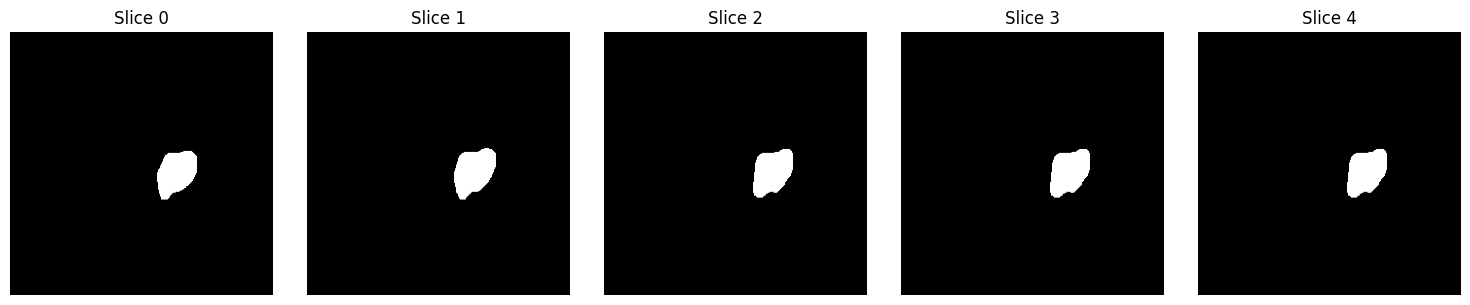

In [ ]:
import matplotlib.pyplot as plt

# Plot each slice in labels_array
fig, axes = plt.subplots(1, labels_array.shape[0], figsize=(15, 3))
# labels_array = np.rot90(labels_array, axes=(1, 2))
for i in range(labels_array.shape[0]):
    axes[i].imshow(labels_array[i], cmap="gray")
    axes[i].set_title(f"Slice {i}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

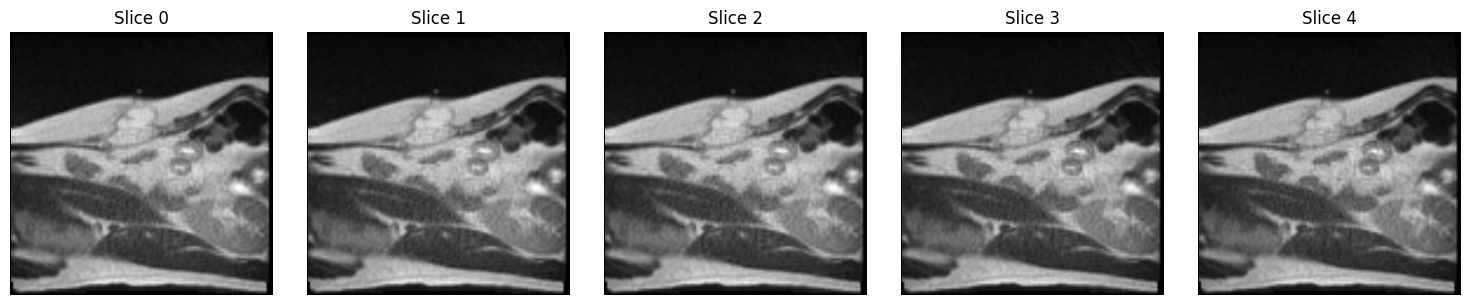

In [80]:
# Plot each slice in suggested_masks_array
fig, axes = plt.subplots(1, suggested_masks_array.shape[0], figsize=(15, 3))
for idx in range(images_array.shape[0]):
    axes[idx].imshow(images_array[idx], cmap="gray")
    axes[idx].set_title(f"Slice {idx}")
    axes[idx].axis("off")
plt.tight_layout()
plt.show()

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


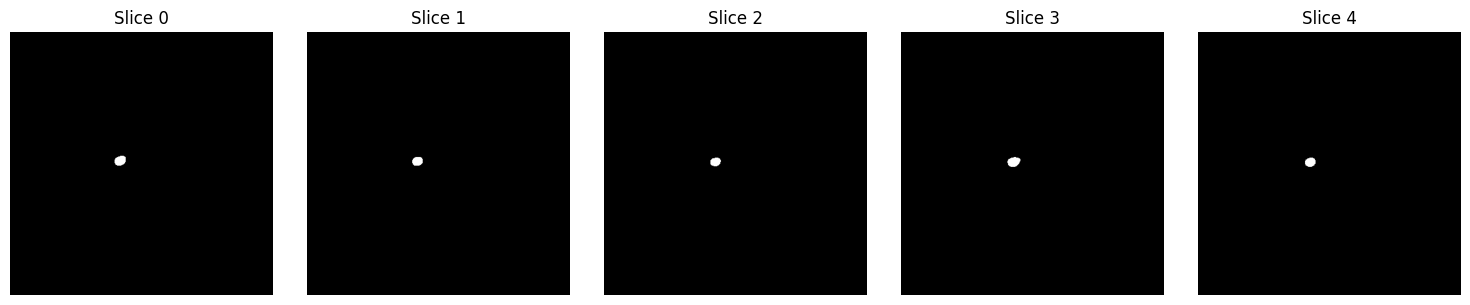

In [75]:
test_path = "/rodata/mnradonc_dev/m299164/trackrad/datasets/nnUNet/nnUNet_results/Dataset491_TrackRadSmoothXB5/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/B_010-0040.nii.gz"
test_file = SimpleITK.ReadImage(str(test_path))
test_array = SimpleITK.GetArrayFromImage(test_file)
fig, axes = plt.subplots(1, test_array.shape[0], figsize=(15, 3))
for i in range(test_array.shape[0]):
    print(np.unique(test_array[i]))
    axes[i].imshow(test_array[i], cmap="gray")
    axes[i].set_title(f"Slice {i}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()